In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df = pd.read_csv('almost.csv', header=0, index_col=0)

df = df.drop(columns=['diff'])
df.index = pd.to_datetime(df.index)

block1 = df[['separator_speed_rpm_pv','mill_dp_mbar_pv','separator_pwr_kw_pv']]
target_block1 = 'separator_pwr_kw_pv'

block2 = df[['separator_speed_rpm_pv','total_feed_perc_pv','fly_ash_1_perc_pv','fly_ash_2_perc_pv',	'main_fan_speed_rpm_pv'	,'grinding_pressure_bar_pv'	,'mill_injection_water_m3/h_pv','bucket_elv_mtr_pwr_kw_pv','mill_dp_mbar_pv']]
target_block2 = 'mill_dp_mbar_pv'


In [3]:
lookback = 50
horizon = 10
window = lookback + horizon
d = block1
# d = block1.rolling(10).mean().dropna()   # tested for each column to remove noise with  a simple roll- mean  but didnt observe any considerable difference
d.head()

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv
date,,,
2019-05-10 11:24:30,735.8900,30.5100,55.7600
2019-05-10 11:25:00,736.6800,31.6100,55.8900
2019-05-10 11:25:30,747.6100,33.7100,56.0600
2019-05-10 11:26:00,747.6100,34.6800,55.6400
2019-05-10 11:26:30,747.5600,34.7100,55.4400


In [40]:
d2 = block2
# d.shape,d2.shape

((328576, 3), (328576, 9))

In [4]:
pwr = d['separator_pwr_kw_pv']
dp_bar = d['mill_dp_mbar_pv']
rpm = d['separator_speed_rpm_pv']
size = len(d)
test_size = int(len(d)*0.3)
valid_size = int(len(d)*0)


tr_pwr = pwr.iloc[:-window-test_size-valid_size]
tr_dp_bar = dp_bar.iloc[:-window-test_size-valid_size]
tr_rpm = rpm.iloc[:-window-test_size-valid_size]

# val_pwr = pwr.iloc[-window-test_size-valid_size:-window-test_size]
# val_dp_bar= dp_bar.iloc[-window-test_size-valid_size:-window-test_size]
# val_rpm = rpm.iloc[-window-test_size-valid_size:-window-test_size]


te_pwr = pwr.iloc[-window-test_size:]  # για να μην εχουμε καθολου overlap και leakage 
te_dp_bar = dp_bar.iloc[-window-test_size:]
te_rpm = rpm.iloc[-window-test_size:]

# tr_pwr.shape[0] + val_pwr.shape[0]+te_pwr.shape[0]
# test = d.iloc[-window-lookback:]
# train = d.iloc[:-window]

# te_pwr

In [5]:
def split_into_windows(series, lookback, horizon,window):

    windows = []
    for i in range(len(series)-lookback-horizon+1):
        windows.append(series[i:i+lookback+horizon].values)
   
    arr = np.array(windows)

    return arr[:, :lookback], arr[:, lookback:]

In [6]:
x_train_pwr, y_train_pwr = split_into_windows(tr_pwr, lookback, horizon,window)
x_train_dp_bar, y_train_dp_bar = split_into_windows(tr_dp_bar, lookback, horizon,window)
x_train_rpm, y_train_rpm = split_into_windows(tr_rpm, lookback, horizon,window)

# val_x_test_pwr, val_y_test_pwr = split_into_windows(val_pwr, lookback, horizon,window)
# val_x_test_dp_bar, val_y_test_dp_bar = split_into_windows(val_dp_bar, lookback, horizon,window)
# val_x_test_rpm, val_y_test_rpm = split_into_windows(val_rpm, lookback, horizon,window)

x_test_pwr, y_test_pwr = split_into_windows(te_pwr, lookback, horizon,window)
x_test_dp_bar, y_test_dp_bar = split_into_windows(te_dp_bar, lookback, horizon,window)
x_test_rpm, y_test_rpm = split_into_windows(te_rpm, lookback, horizon,window)


In [7]:
## unify xtrain across features
print(x_train_pwr.shape,x_train_rpm.shape,x_train_dp_bar.shape)
print(y_train_pwr.shape,y_train_rpm.shape,y_train_dp_bar.shape)

# print(val_x_test_pwr.shape,val_x_test_rpm.shape,val_x_test_dp_bar.shape)
# print(val_y_test_pwr.shape,val_y_test_rpm.shape,val_y_test_dp_bar.shape)

(229885, 50) (229885, 50) (229885, 50)
(229885, 10) (229885, 10) (229885, 10)


In [8]:
def normalize(x):
    mn = x.min(axis=1).reshape(-1, 1)
    mx = x.max(axis=1).reshape(-1, 1)
    x_sc = (x - mn) / (mx - mn) # min max scale
    return x_sc

#
# x_train_block1_sc = normalize(x_train_block1)
# # val_x_test_block1_sc = normalize(val_x_test_block1)
# x_test_block1_sc = normalize(x_test_block1)

####
####   FIRST WE SCALE AND THEN WE CONCAT TO ENSURE DIFFERENT RANGES ARE NORMALIZED ACCORDINGLY PER WINDOW
x_train_pwr_sc = normalize(x_train_pwr)
x_train_dp_bar_sc = normalize(x_train_dp_bar)
x_train_rpm_sc = normalize(x_train_rpm)


x_test_pwr_sc = normalize(x_test_pwr)
x_test_dp_bar_sc = normalize(x_test_dp_bar)
x_test_rpm_sc = normalize(x_test_rpm)


# val_x_test_pwr_sc = normalize(val_x_test_pwr)
# val_x_test_dp_bar_sc = normalize(val_x_dp_bar)
# val_x_test_rpm_sc  = normalize(val_x_test_rpm)

In [9]:
## concatenation of each feature lookback window to create train/test/val block
#
### NNOTE!!! containing power (separator power) was on purpose , as it is the target value. We can exclude it from train set so that our model takes a more classical ML Approach that bases predictions only in features (this was noted by TITAN "examiners") 

x_train_block1_sc = np.concatenate((x_train_pwr_sc, x_train_dp_bar_sc,x_train_rpm_sc), axis=1)
x_test_block1_sc = np.concatenate((x_test_pwr_sc, x_test_dp_bar_sc,x_test_rpm_sc), axis=1)
# val_x_test_block1 = np.concatenate((val_x_test_pwr, val_x_test_dp_bar,val_x_test_rpm),axis=1)


## Validation 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV



lr = LinearRegression()
lr.fit(x_train_block1_sc, y_train_pwr)
lr_preds = lr.predict(val_x_test_block1_sc)
lr_mse = mean_squared_error(val_y_test_pwr, lr_preds)
lr_mae = mean_absolute_error(val_y_test_pwr, lr_preds)

param_grid = {"alpha": [0.1, 0.25, 0.5, 0.75, 1]}
lasso = GridSearchCV(Lasso(), param_grid)
# lasso = Lasso()
lasso.fit(x_train_block1_sc, y_train_pwr)
lasso_preds = lasso.predict(val_x_test_block1_sc)
las_mse = mean_squared_error(val_y_test_pwr, lasso_preds)
las_mae = mean_absolute_error(val_y_test_pwr, lasso_preds)

param_grid = {"alpha": [0.1, 0.25, 0.5, 0.75, 1, 1.2]}
ridge = GridSearchCV(Ridge(), param_grid)
# ridge = Ridge()
ridge.fit(x_train_block1_sc, y_train_pwr)
ridge_preds = ridge.predict(val_x_test_block1_sc)
rid_mse = mean_squared_error(val_y_test_pwr, ridge_preds)
rid_mae = mean_absolute_error(val_y_test_pwr, ridge_preds)

param_grid = {"alpha": [0.1, 0.25, 0.5, 0.75, 1], "l1_ratio": [0.2, 0.5, 0.7, 0.9]}
eln = GridSearchCV(ElasticNet(), param_grid)
# eln = ElasticNet()
eln.fit(x_train_block1_sc, y_train_pwr)
eln_preds = eln.predict(val_x_test_block1_sc)
eln_mse = mean_squared_error(val_y_test_pwr, eln_preds)
eln_mae = mean_absolute_error(val_y_test_pwr, eln_preds)


print("Linear Models Results :")

print("Linear Regression: ", lr_mse, lr_mae)
print("Lasso: ", las_mse, las_mae)
print("Ridge: ", rid_mse, rid_mae)
print("ElasticNet: ", eln_mse, eln_mae)


In [ ]:
print(lasso.best_params_)
print(ridge.best_params_)
print(eln.best_params_)

In [ ]:
plt.figure(figsize=(10,5))
plt.suptitle('Vertically stacked subplots')

r = 1000
# we can check for custome time spaces with range(fr,r) and [fr:r,0 or 1 or 2 or... (desired time shift as we predict 10 values at once)]
# r = 20000
# fr = 19000
# range(r)
plt.plot(range(r), val_y_test_pwr[0:r,0],label='real',lw=1.5)
plt.plot(range(r), lr_preds[0:r,0],label='linear',lw=1.5)
plt.plot(range(r), lasso_preds[0:r,0],label='lasso',lw=1.5)
plt.plot(range(r), ridge_preds[0:r,0],label='ridge',lw=1.5)
plt.plot(range(r), eln_preds[-0:r,0],label='eln',lw=1.5)

plt.legend()

In [ ]:
plt.plot(val_pwr)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

param_grid = {"max_depth": [2, 4, 5], "min_samples_leaf": [1, 3, 5]}
dt = GridSearchCV(DecisionTreeRegressor(), param_grid)
# dt = DecisionTreeRegressor(max_depth=4)
dt.fit(x_train_block1_sc, y_train_pwr)
dt_preds = dt.predict(val_x_test_block1_sc)
dt_mse = mean_squared_error(val_y_test_pwr, dt_preds)
dt_mae = mean_absolute_error(val_y_test_pwr, dt_preds)

param_grid = {"n_estimators":[2,5,8,10]}
rf = GridSearchCV(RandomForestRegressor(), param_grid)
# rf = RandomForestRegresso;r(n_estimators=5)
rf.fit(x_train_block1_sc, y_train_pwr)
rf_preds = rf.predict(val_x_test_block1_sc)
rf_mse = mean_squared_error(val_y_test_pwr, rf_preds)
rf_mae = mean_absolute_error(val_y_test_pwr, rf_preds)

# gb=GradientBoostingRegressor(loss='ls',n_estimators=10)
# gb.fit(x_train_block1, y_train_pwr)
# gb_preds = gb.predict(x_test_block1)
# gb_mse = mean_squared_error(y_test_pwr, gb_preds)
# gb_mae = mean_absolute_error(y_test_pwr, gb_preds)

print("Decision Tree: ", dt_mse, dt_mae)
print("RandomForest: ", rf_mse, rf_mae)

In [ ]:
plt.figure(figsize=(10,5))
plt.suptitle('Vertically stacked subplots')

r = 1000   # declare size of time we want to see predictions

# we check each space  for next prediction
plt.plot(range(r), val_y_test_pwr[0:r,0],label='real',lw=1.5)
plt.plot(range(r), dt_preds[0:r,0],label='Decision tree',lw=1.5)
plt.plot(range(r), rf_preds[0:r,0],label='Random Forest',lw=1.5)

plt.legend()

# Test Set

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV


lr = LinearRegression()
lr.fit(x_train_block1_sc, y_train_pwr)
lr_preds = lr.predict(x_test_block1_sc)
lr_mse = mean_squared_error(y_test_pwr, lr_preds)
lr_mae = mean_absolute_error(y_test_pwr, lr_preds)

lasso = Lasso(alpha=0.1)
lasso.fit(x_train_block1_sc, y_train_pwr)
lasso_preds = lasso.predict(x_test_block1_sc)
las_mse = mean_squared_error(y_test_pwr, lasso_preds)
las_mae = mean_absolute_error(y_test_pwr, lasso_preds)


ridge = Ridge(alpha=0.1)
ridge.fit(x_train_block1_sc, y_train_pwr)
ridge_preds = ridge.predict(x_test_block1_sc)
rid_mse = mean_squared_error(y_test_pwr, ridge_preds)
rid_mae = mean_absolute_error(y_test_pwr, ridge_preds)


eln = ElasticNet(alpha=0.1,l1_ratio=0.2)# from param_grid on validation set
eln.fit(x_train_block1_sc, y_train_pwr)
eln_preds = eln.predict(x_test_block1_sc)
eln_mse = mean_squared_error(y_test_pwr, eln_preds)
eln_mae = mean_absolute_error(y_test_pwr, eln_preds)


print("Linear Models Results :")
print("Linear Regression: ", lr_mse, lr_mae)
print("Lasso: ", las_mse, las_mae)
print("Ridge: ", rid_mse, rid_mae)
print("ElasticNet: ", eln_mse, eln_mae)

Linear Models Results :
Linear Regression:  3.4438114591253184 1.3295361433052677
Lasso:  3.470755261603956 1.3364203908607195
Ridge:  3.443811314924693 1.3295361037931543
ElasticNet:  3.4686465974545504 1.3344282413713857


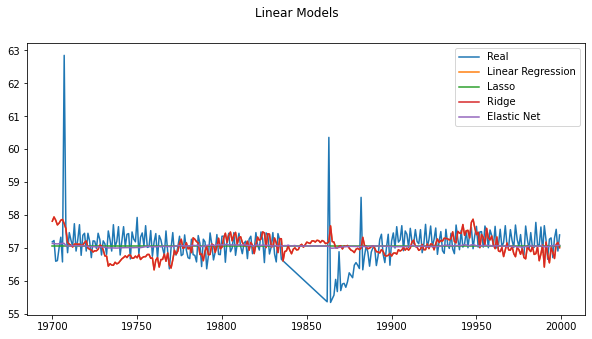

In [11]:
plt.figure(figsize=(10,5))
plt.suptitle('Linear Models')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), lr_preds[fr:r,0],label='Linear Regression',lw=1.5)
plt.plot(range(fr,r), lasso_preds[fr:r,0],label='Lasso',lw=1.5)
plt.plot(range(fr,r), ridge_preds[fr:r,0],label='Ridge',lw=1.5)
plt.plot(range(fr,r), eln_preds[fr:r,0],label='Elastic Net',lw=1.5)
plt.legend()


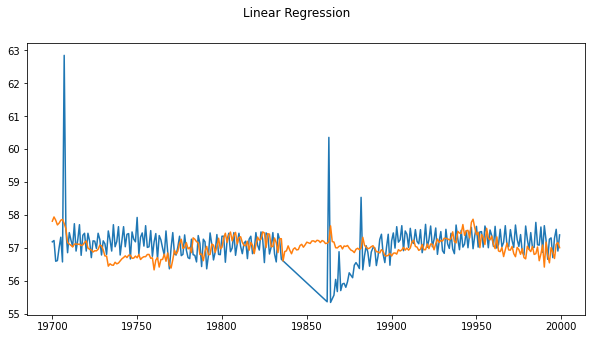

In [12]:
plt.figure(figsize=(10,5))
plt.suptitle('Linear Regression')
r = 20000
fr = 19700
plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), lr_preds[fr:r,0],label='Linear Regression',lw=1.5)

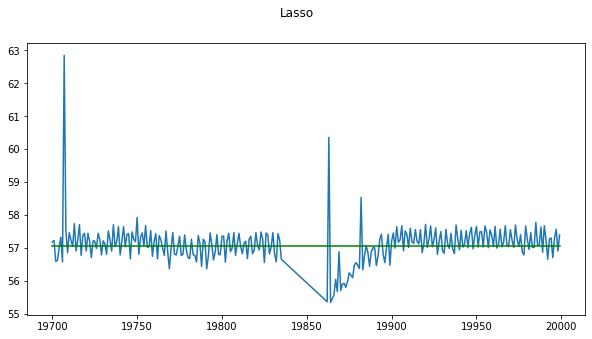

In [13]:
plt.figure(figsize=(10,5))
plt.suptitle('Lasso')
plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), lasso_preds[fr:r,0],label='Lasso',lw=1.5,color='g')


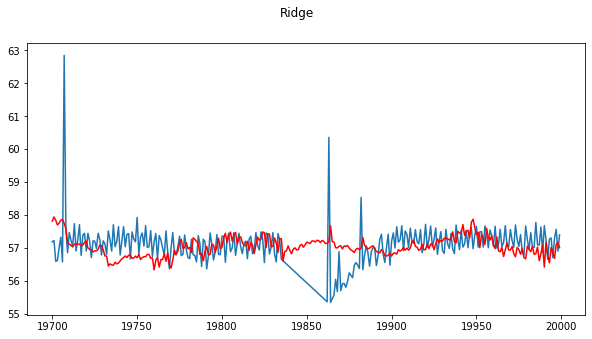

In [14]:
plt.figure(figsize=(10,5))
plt.suptitle('Ridge')
plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), ridge_preds[fr:r,0],label='Lasso',lw=1.5,color='r')

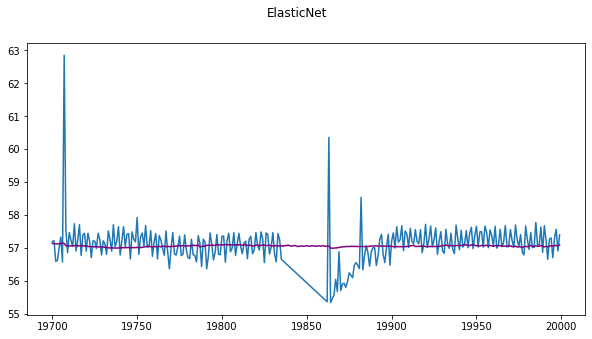

In [15]:
plt.figure(figsize=(10,5))
plt.suptitle('ElasticNet')
plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), eln_preds[fr:r,0],label='Lasso',lw=1.5,color='purple')

## Tree Models With Sliding Window

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

dt = DecisionTreeRegressor(max_depth=2)
dt.fit(x_train_block1_sc, y_train_pwr)
dt_preds = dt.predict(x_test_block1_sc)
dt_mse = mean_squared_error(y_test_pwr, dt_preds)
dt_mae = mean_absolute_error(y_test_pwr, dt_preds)

rf = RandomForestRegressor(n_estimators=5)
rf.fit(x_train_block1_sc, y_train_pwr)
rf_preds = rf.predict(x_test_block1_sc)
rf_mse = mean_squared_error(y_test_pwr, rf_preds)
rf_mae = mean_absolute_error(y_test_pwr, rf_preds)

print("Decision Tree: ", dt_mse, dt_mae)
print("RandomForest: ", rf_mse, rf_mae)

Decision Tree:  3.1939964585887513 1.3004562463136806
RandomForest:  3.1912861733266547 1.2773539314687974


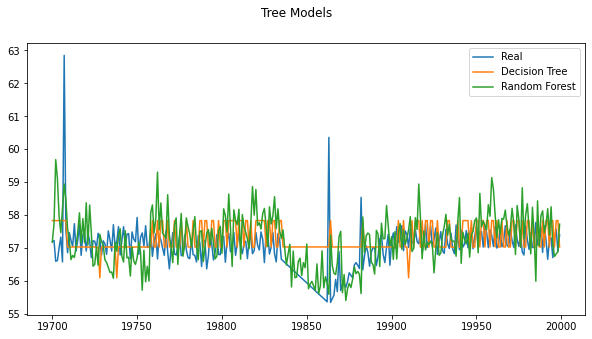

In [17]:
plt.figure(figsize=(10,5))
plt.suptitle('Tree Models')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), dt_preds[fr:r,0],label='Decision Tree',lw=1.5)
plt.plot(range(fr,r), rf_preds[fr:r,0],label='Random Forest',lw=1.5)
# plt.plot(range(fr,to), gb_preds[-(to-fr):,0],label='Gradient Boosting',lw=1.5)

plt.legend()

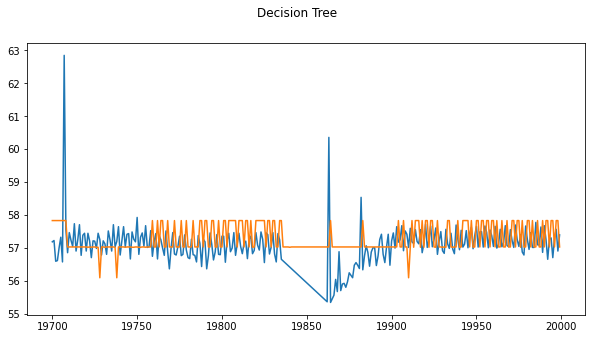

In [18]:
plt.figure(figsize=(10,5))
plt.suptitle('Decision Tree')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), dt_preds[fr:r,0],label='Decision Tree',lw=1.5)

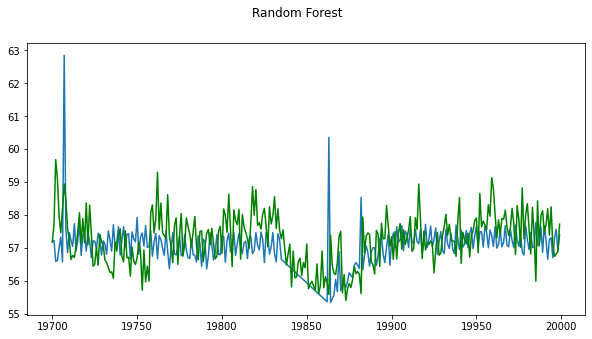

In [19]:
plt.figure(figsize=(10,5))
plt.suptitle('Random Forest')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='Real',lw=1.5)
plt.plot(range(fr,r), rf_preds[fr:r,0],label='Random Forest',lw=1.5,color='g')

## NeuralNetworks with sliding window


In [20]:
import tensorflow as tf

In [21]:
x_train_block1_sc.shape

(229885, 150)

In [22]:
inp = tf.keras.layers.Input(shape=(lookback*3,))  #  *3 multiplication has to be done as input must get 150 (50 *3) ---- Lookback * number_of_features that model is based on

hid = tf.keras.layers.Dense(100, activation='relu')(inp)

out = tf.keras.layers.Dense(horizon)(hid)


dense1 = tf.keras.models.Model(inp, out)
dense1.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])

h = dense1.fit(x_train_block1_sc, y_train_pwr, epochs=50)

Epoch 1/50
7184/7184 [==============================] - 6s 728us/step - loss: 4.6805 - mae: 4.6805 - mse: 134.0489
Epoch 2/50
7184/7184 [==============================] - 5s 692us/step - loss: 1.4891 - mae: 1.4891 - mse: 6.8676
Epoch 3/50
7184/7184 [==============================] - 5s 681us/step - loss: 0.8332 - mae: 0.8332 - mse: 1.3262
Epoch 4/50
7184/7184 [==============================] - 5s 672us/step - loss: 0.7981 - mae: 0.7981 - mse: 1.2021
Epoch 5/50
7184/7184 [==============================] - 5s 661us/step - loss: 0.7771 - mae: 0.7771 - mse: 1.1277
Epoch 6/50
7184/7184 [==============================] - 5s 660us/step - loss: 0.7630 - mae: 0.7630 - mse: 1.0939
Epoch 7/50
7184/7184 [==============================] - 5s 692us/step - loss: 0.7558 - mae: 0.7558 - mse: 1.0861
Epoch 8/50
7184/7184 [==============================] - 5s 709us/step - loss: 0.7609 - mae: 0.7609 - mse: 1.0933
Epoch 9/50
7184/7184 [==============================] - 5s 656us/step - loss: 0.7456 - mae: 0.

In [23]:
_, mae, mse = dense1.evaluate(x_test_block1_sc, y_test_pwr)


3081/3081 [==============================] - 1s 442us/step - loss: 1.2826 - mae: 1.2826 - mse: 3.1393


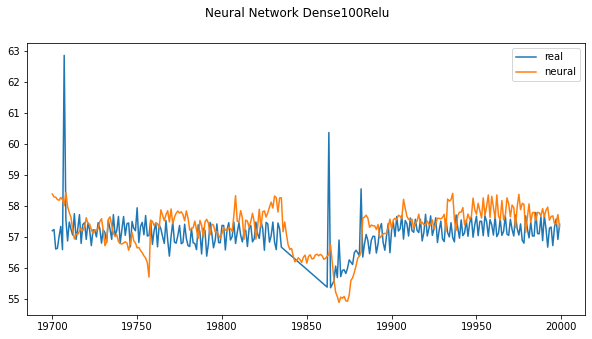

In [24]:
nn_preds = dense1.predict(x_test_block1_sc)

plt.figure(figsize=(10,5))
plt.suptitle('Neural Network Dense100Relu')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='real',lw=1.5)
plt.plot(range(fr,r), nn_preds[fr:r,0],label='neural',lw=1.5)

plt.legend()

### Sktime algos like Naive,Exponential

In [ ]:
from sktime.forecasting.all import ForecastingHorizon, NaiveForecaster, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.all import ExponentialSmoothing

y_train, y_test = temporal_train_test_split(pwr.to_period('10T'), test_size=250)
y_train_rpm, y_test_rpm = temporal_train_test_split(rpm.to_period('10T'), test_size=250)
y_train_bar, y_test_bar = temporal_train_test_split(pwr.to_period('10T'), test_size=250)
print(type(y_train))
y_train = y_train_bar.append(y_test_rpm.append(y_test))
# plot_series(y_train[-250:-1], y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])


fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

naive = NaiveForecaster(strategy='mean', window_length=window)
naive.fit(y_train[-250:-1])
naive_preds = naive.predict(fh)
print("shape of preds and test ", y_test.shape,naive_preds.shape)
plt.plot(y_test.values)


# plt.plot(naive_preds.values,color='r')
# plot_series( y_test, naive_preds, labels=['train', 'test', 'pred'])

In [ ]:
plt.plot(naive_preds.values,color='r')

In [ ]:
plt.plot(es_preds.values,color='r')

In [ ]:

###   we tried exponential but we figured that it needs manual coding to fix inconsistency with time gaps and we didnt push any further
###
from sktime.forecasting.all import ExponentialSmoothing  #

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


param_grid={'n_neighbors':[3,5,7,11],'weights':['uniform','distance']}

# knn = GridSearchCV(KNeighborsRegressor(),param_grid,verbose=1)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train_block1_sc,y_train_pwr)
knn_preds = knn.predict(x_test_block1_sc)
knn_mse = mean_squared_error(y_test_pwr, knn_preds)
knn_mae = mean_absolute_error(y_test_pwr, knn_preds)

print("Kneighbors: ", knn_mse, knn_mae)

Kneighbors:  3.6187949235923775 1.4024607669219102


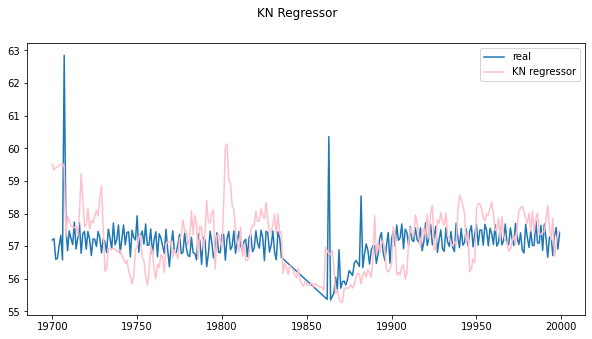

In [26]:
plt.figure(figsize=(10,5))
plt.suptitle('KN Regressor')

r = 20000
fr = 19700

plt.plot(range(fr,r), y_test_pwr[fr:r,0],label='real',lw=1.5)
plt.plot(range(fr,r), knn_preds[fr:r,0],label='KN regressor',lw=1.5,color='pink')

plt.legend()